<div align="center">
<a href="https://vbti.nl"><img src="https://docs.google.com/uc?export=download&id=1DdCGllL51O5wBuiI0rwygofKx3YIDPHX" width="400"></a>
</div>


# Greenhouse Environment

In this notebook we are going to take the simulation model developed in the previous notebook and use Reinforcement Learning to train an agent for controling the greenhouse decision variables. We are going to use OpenAI Gym interface, since it allows for an easy reuse of the agents across different environments and domains.

## Interface
In order to comply with Gym interface we would need our class to have two attributes:
- ```env.observation_space``` - observation space of the environment
- ```env.action_space``` - action space of the environment
`env.observation_space` will define the **Observation Space**, the space of all possible observations that an agent can receive. At the same time `env.action_space` determines the **Action Space**, space of all possible actions. When constructing an agent we will use this information to define the size of a table or a neural network.

Communication between the environment and the agent will be done through the following methods:
- ```env.reset()``` - resets the state of the environment and returns an initial observation.
- ```env.step(action)``` - run one timestep of the environment's dynamics. When end of episode is reached, you are responsible for calling ```reset()``` to reset this environment's state.

When calling the `env.reset()` we need to return an initial *observation*.

```python
obs = env.reset()
```

When `env.step()` is called we need to return a tuple with 4 values:
1. Next observation
2. Reward for the previous action
3. A boolean flag whether an episode is done or not
4. Dictionary with some other information

```python
next_obs, reward, done, info = env.reset()
```


```python
class GreenhouseEnv(gym.Env):
    def __init__(self, config=None):
        super(GreenhouseEnv, self).__init__()
        self.config = config or dict()
        self.max_episode_time = self.config.get('max_episode_time', 7 * 24 * 60)

        greenhouse_config = self.config.get('greenhouse_config', dict())
        self.greenhouse_model = Greenhouse(weather_model=Weather(), **greenhouse_config)

        sample_obs = self.greenhouse_model.reset()
        high = np.array([np.inf] * sample_obs.size())
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

        # Define the range of values available for actions
        ranges = [
            [0, 1],
            [0, 1],
            [0, 1],
            [0, 1],
            [0, 1],
        ]
        # Create a cartesian product of all of the actions
        possible_actions = list(product(*ranges))
        # Create a mapping from a number to a vector representation of an action and back
        self.action_vec_to_num = {}
        self.action_num_to_vec = {}
        for i, action in enumerate(possible_actions):
            self.action_vec_to_num[action] = i
            self.action_num_to_vec[i] = action

        self.action_space = spaces.Discrete(len(self.action_vec_to_num))
```
First of all we would like to have a nice way of configuring our environment. For this we are going to pass a configuration dictionary to the `GreenhouseEnv` that contains all of the parameters needed to configure the environment and the simulation.

Next we define `reset()` and `step()` methods. Since we have prepared almost everything in the `Greenhouse` simulation class we only need to pass on the calls to the simulation object and return the observations as a numpy object.
        
```python
class Greenhouse(gym.Env):
    def reset(self):
        obs_np = self.greenhouse_model.reset().to_numpy()
        return obs_np

    def step(self, action):
        # if action is an integer covert it into a vector form
        if isinstance(action, int):
            action = self.action_num_to_vec[action]
        
        # create a greenhouse action
        greenhouse_action = GreenhouseAction(
            heater=action[0],
            window=action[1],
            vapor_supply=action[2],
            CO2_supply=action[3],
            light=action[4],
        )
        
        # perform a step in a simulation
        greenhouse_state, reward, reward_dict = self.greenhouse_model.step(greenhouse_action)

        done = self.greenhouse_model.time >= self.max_episode_time
        info = {**reward_dict}

        return greenhouse_state.to_numpy(), reward, done, info
```

# State modeling

When taking into the account the state of the environment it is important to check what kind of values can you expect. For now, we just took the numbers provided by a simulation model. Run the environment couple of times, collect the data and check the statistics of our data. 

In [161]:
%load_ext autoreload
%autoreload 2

from greenhouse.environment import GreenhouseEnv
import numpy as np

env = GreenhouseEnv()

def sample_trajectories(env, agent=None, num_episodes=100, include_actions=False):
    obs = env.reset()
    done = False
    observed_values = []
    from collections import defaultdict
    step_info = defaultdict(list)
    for i in range(num_episodes):
        while not done:
            if agent is None:
                action = env.action_space.sample()
            else:
                action = agent.compute_action(obs)
            next_obs, reward, done, info = env.step(action)
            next_obs_n = env.greenhouse_model.get_obs().to_numpy()
            if isinstance(action, int):
                action = env.action_num_to_vec[action]
            
            if include_actions:
                observed_values.append(np.concatenate([next_obs_n, np.asarray(action)]))
            else:
                observed_values.append(obs)
                                       
            obs = next_obs
    observed_values = np.asarray(observed_values)
    return observed_values
random_trajectories = sample_trajectories(env)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
import pandas as pd
state = env.greenhouse_model.reset()
pd.DataFrame(random_trajectories, columns=state.labels()).describe()

Time [min]  GH Temperature [C]  GH Rel. Humidity [%]  GH CO2 [ppm]  \
count   2016.000000         2016.000000           2016.000000   2016.000000   
mean    5037.500000           26.332146             62.834233   1416.798750   
std     2910.566955            5.863938             14.395371    527.001029   
min        0.000000           18.581370             23.386816    333.333333   
25%     2518.750000           21.894192             52.146745    988.492953   
50%     5037.500000           24.207181             67.535985   1365.033255   
75%     7556.250000           29.353772             74.130805   1791.242146   
max    10075.000000           45.533374             86.348887   3183.725546   

       Weather | Temperature [C]  Weather | Rel. Humidity [%]  \
count                2016.000000                  2016.000000   
mean                   18.788442                    76.506448   
std                     1.640002                    10.506837   
min                    15.000000                    43.000000   
25%                    17.700000                    69.900000   
50%                    18.800000                    78.200000   
75%                    19.900000                    84.000000   
max                    23.000000                    94.400000   

       Weather | Solar power [W/m2]  Weather | CO2 [ppm]  \
count                   2016.000000               2016.0   
mean                     150.229167                350.0   
std                      209.185639                  0.0   
min                        0.000000                350.0   
25%                        0.000000                350.0   
50%                       55.000001                350.0   
75%                      227.000000                350.0   
max                      879.999999                350.0   

       Plant | CO2 absorption rate [g/m2/h]  Plant | CO2 total [gram]  
count                           2016.000000               2016.000000  
mean                              -0.000152                 46.172120  
std                                0.000139                 27.009836  
min                               -0.000381                 -0.508333  
25%                               -0.000278                 24.958325  
50%                               -0.000167                 46.591842  
75%                                0.000028                 67.840827  
max                                0.000028                 92.043529

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning:

WARN: Box bound precision lowered by casting to float32



Text(0, 0.5, 'time [minutes]')

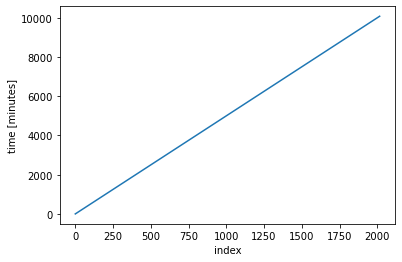

In [163]:
env = GreenhouseEnv()

random_traj = sample_random_trajectories(env, num_episodes=1)

import matplotlib.pyplot as plt

plt.plot(random_traj[:, 0])
plt.xlabel('index')
plt.ylabel('time [minutes]')

We know that time is going to get incremented by 5 every timestep. We could transform this feature with some cyclic function, so that our agent can get the notion of day and night. We are going to add two features for time.

$$
    x_0 = \operatorname{sin} \left( \frac{t * 2 \pi}{24 * 60} \right)
$$


$$
    x_1 = \operatorname{cos} \left( \frac{t * 2 \pi}{24 * 60} \right)
$$

For all the other features we are going to normalize them between -1 and 1 using **min-max** normalization. The minumum and maximum of the real values we are going to estimate from a number of random trajectories.

In [164]:
def min_max_normalize(v, low_v, high_v, low_target, high_target):
    """
    Rescale the value one range [low_v, high_v] to another [low_target, high_target]
    Formula taken from here: https://en.wikipedia.org/wiki/Feature_scaling
    :param v: value to rescale
    :param low_v: min(v) lowest value for v
    :param high_v: max(v) highest value for v
    :param low_target: a lower after rescale
    :param high_target: b higher after rescale
    :return: v_rescaled
    """
    if high_v - low_v == 0:
        v_rescaled = 0
    else:
        v_rescaled = low_target + (v - low_v) * (high_target - low_target) / (
            high_v - low_v
        )
    return v_rescaled


# Record min and max for all features
scaling_values = {}
for i in range(random_trajectories.shape[1]):
    min_, max_ = random_trajectories[:, i].min(), random_trajectories[:, i].max()
    scaling_values[i] = (min_, max_)

In [165]:
import gym
import numpy as np

class TransformObservation(gym.ObservationWrapper):
    def __init__(self, config):
        super().__init__(config)
        self.observation_space = gym.spaces.Box(-np.inf, np.inf, shape=(self.observation_space.shape[0] + 1, ))
    
    
    def normalize_features(self, obs):
        new_obs = np.zeros(obs.shape[0] + 1, dtype=np.float32)
        new_obs[0] = np.sin(obs[0] * 2 * np.pi / (24 * 60))
        new_obs[1] = np.cos(obs[0] * 2 * np.pi / (24 * 60))

        for i in range(2, len(obs)):
            low_v, high_v = scaling_values[i - 1]
            new_obs[i] = min_max_normalize(obs[i - 1], low_v, high_v, -1, 1)

        return new_obs
    
    def observation(self, obs):
        return self.normalize_features(obs)

env = TransformObservation(GreenhouseEnv())

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning:

WARN: Box bound precision lowered by casting to float32



In [166]:
random_trajectory_normalized = sample_random_trajectories(env, 1)
pd.DataFrame(random_trajectory_normalized).describe()

0             1            2            3            4   \
count  2.016000e+03  2.016000e+03  2016.000000  2016.000000  2016.000000   
mean   0.000000e+00  0.000000e+00    -0.440290     0.273279    -0.255656   
std    7.072822e-01  7.072822e-01     0.439303     0.446131     0.362325   
min   -1.000000e+00 -1.000000e+00    -0.973935    -0.999469    -1.026601   
25%   -7.071068e-01 -7.071068e-01    -0.765481    -0.036366    -0.560600   
50%   -3.673941e-16  1.836970e-16    -0.597243     0.384800    -0.279095   
75%    7.071068e-01  7.071068e-01    -0.214946     0.625554     0.042545   
max    1.000000e+00  1.000000e+00     0.990241     0.978991     0.634956   

                5            6            7       8            9       10  
count  2016.000000  2016.000000  2016.000000  2016.0  2016.000000  2016.0  
mean     -0.052889     0.303753    -0.658570     0.0     0.130097     0.0  
std       0.410000     0.408826     0.475422     0.0     0.677622     0.0  
min      -1.000000    -1.000000    -1.000000     0.0    -0.975869     0.0  
25%      -0.325000     0.046693    -1.000000     0.0    -0.486754     0.0  
50%      -0.050000     0.369650    -0.875000     0.0     0.046543     0.0  
75%       0.225000     0.595331    -0.484091     0.0     1.000000     0.0  
max       1.000000     1.000000     1.000000     0.0     1.000000     0.0

Text(0, 0.5, 'time feature')

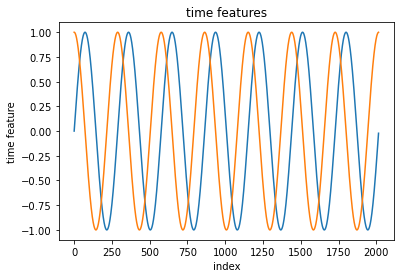

In [27]:
plt.title('time features')

plt.plot(random_trajectory_normalized[:, 0])
plt.plot(random_trajectory_normalized[:, 1])
plt.xlabel('index')
plt.ylabel('time feature')

# Scenario 1: No costs

In [28]:
env_config = {
    'greenhouse_config': {
        'cost_heat': 0,
        'cost_CO2': 0,
        'cost_vapor': 0,
        'cost_light': 0
    }
}

In [50]:
import gym
from QLearning.dqn import DeepQNetwork, DoubleDQN, DuelingDDQN, NoisyDuelingDDQN, EpsilonGreedyAgent
from os.path import join

from greenhouse.environment import GreenhouseEnv

EXPERIMENT_FOLDER = join('Experiments', 'greenhouse_dqn_1')
save_interval = 100

env = TransformObservation(GreenhouseEnv(env_config))
        
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

q_network = DeepQNetwork(
    state_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
    learning_rate=0.00025,
    gamma=0.9,
    use_cnn=False,
    mlp_n_hidden=(32, 32),
    mlp_act_f="tanh",
    mlp_value_n_hidden=(64, ),
    mlp_value_act_f="tanh")
# q_network.load(filepath='Experiments/greenhouse_dqn_1/last')

agent = EpsilonGreedyAgent(
    n_actions=env.action_space.n,
    network=q_network,
    replay_capacity=50000,
    gamma=0.99,  # discount of future rewards
    training_start=100,  # start training after x number of steps
    training_interval=3,  # train every x steps
    batch_size=32,
    start_epsilon=1.0,
    end_epsilon=0.02,
    epsilon_decay=1e-5,
    root_folder=EXPERIMENT_FOLDER,
    save_best=True,
    save_interval=save_interval)

# agent.epsilon = 0.02

# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

Observation space: Box(-inf, inf, (11,), float32)
Action space: Discrete(32)


C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


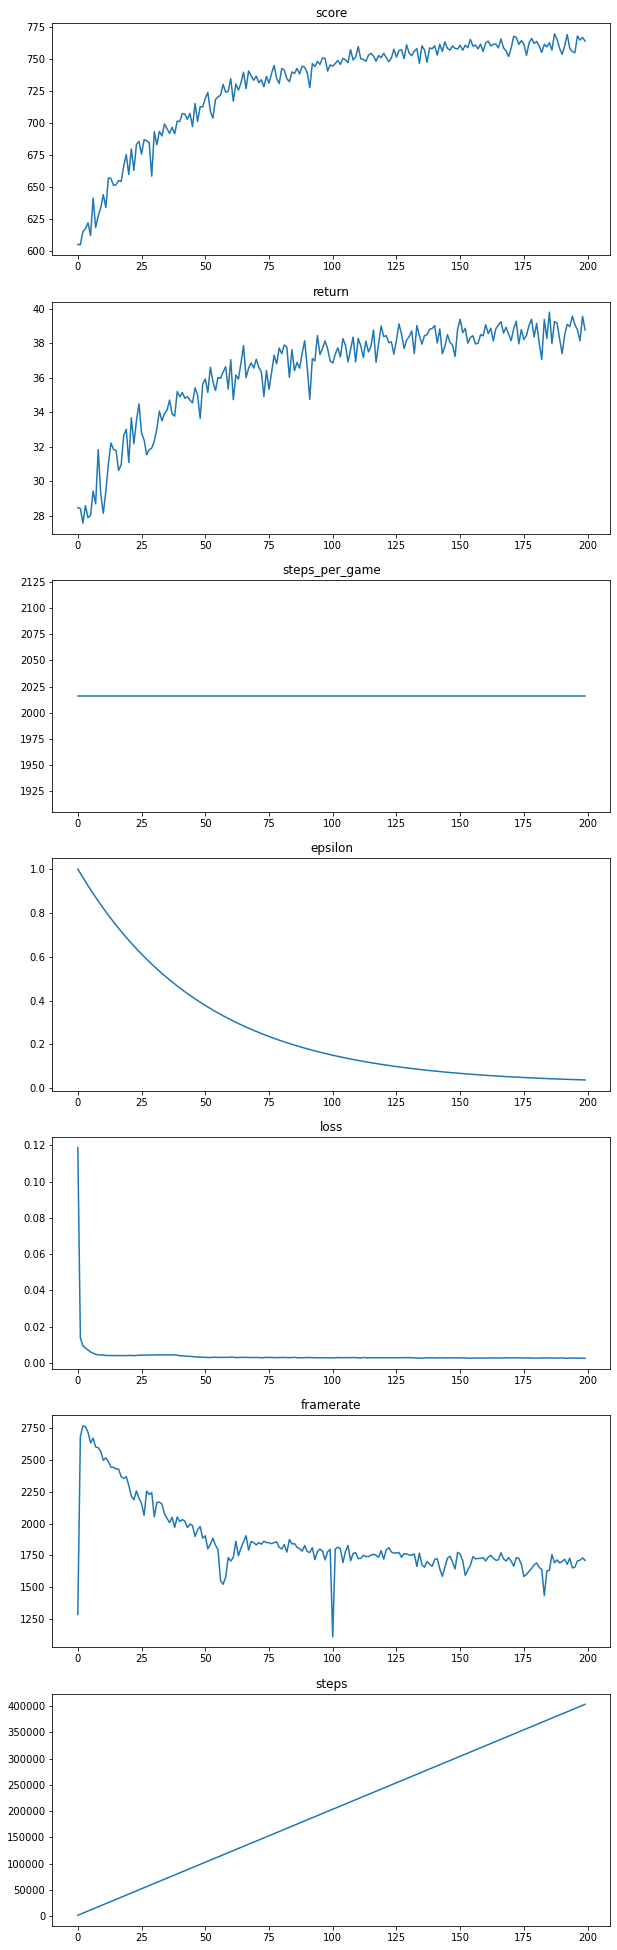

In [51]:
# Cell to train the agent. If you want to load the weights, skip this cell.
from QLearning.dqn import run_experiment

history = run_experiment(env, agent, runs=200, history=history,
               plot_stats=[
                   'score',
                   'return',
                   'steps_per_game',
                   'epsilon',
                   'loss',
                   'framerate',
                   'steps'
               ],
              plot_period=10)
env.close()

Let us compare the performance of the our DQN Agent against the heuristic.

In [30]:
def visualize_episode(env, agent):
    from collections import defaultdict
    
    history = []
    step_info = defaultdict(list)
    summary = {}
    
    # reset an environment and get first observation
    obs = env.reset()
    done = False
    while not done:
        # get an action from the agent
        action = agent.compute_action(obs)
        # perform an environment step
        next_obs, reward, done, info = env.step(action)
        # get non normalized observation
        non_norm_next_obs = env.greenhouse_model.get_obs().to_numpy()
        # in case the agent's action is an integer convert it to the vector form to save it in a history
        if isinstance(action, int):
            action = env.action_num_to_vec[action]
        history.append(np.concatenate([non_norm_next_obs, action]))
        # prepeare the next observation for the next step
        obs = next_obs
        # save all of the extra variables provided by info
        for k, v in info.items():
            step_info[k].append(v)
            
    import matplotlib.pyplot as plt
    from greenhouse.simulation import plot_history
    plot_history(np.asarray(history))
    plt.show()
    
#     from plotly import graph_objects as go
#     fig = go.Figure()
#     for k, v in step_info.items():
#         fig.add_trace(go.Scatter(x=np.arange(len(v)), y=v, name=k))
#     fig.show()
    
    history = np.asarray(history)
    day_mask = ((history[:, 0] / 60) % 24 > 5.0) * ((history[:, 0] / 60) % 24 < 23.0)
    summary['mean_day_temp'] = history[:, 1][day_mask].mean()
    summary['mean_night_temp'] = history[:, 1][~day_mask].mean()
    
    # compute cumulative individual rewards
    cumulative_rewards = {}
    for k, v in step_info.items():
        sum_rewards = sum(step_info[k])
        cumulative_rewards[k] = sum_rewards
        summary[k] = sum_rewards
        
    summary['total_cost'] = sum([v for k, v in cumulative_rewards.items() if 'cost' in k])
    summary['total_co2_absorbtion'] = sum([v for k, v in cumulative_rewards.items() if 'cost' not in k])
    summary['total_reward'] = summary['total_cost'] + summary['total_co2_absorbtion']
    
    return history, summary

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


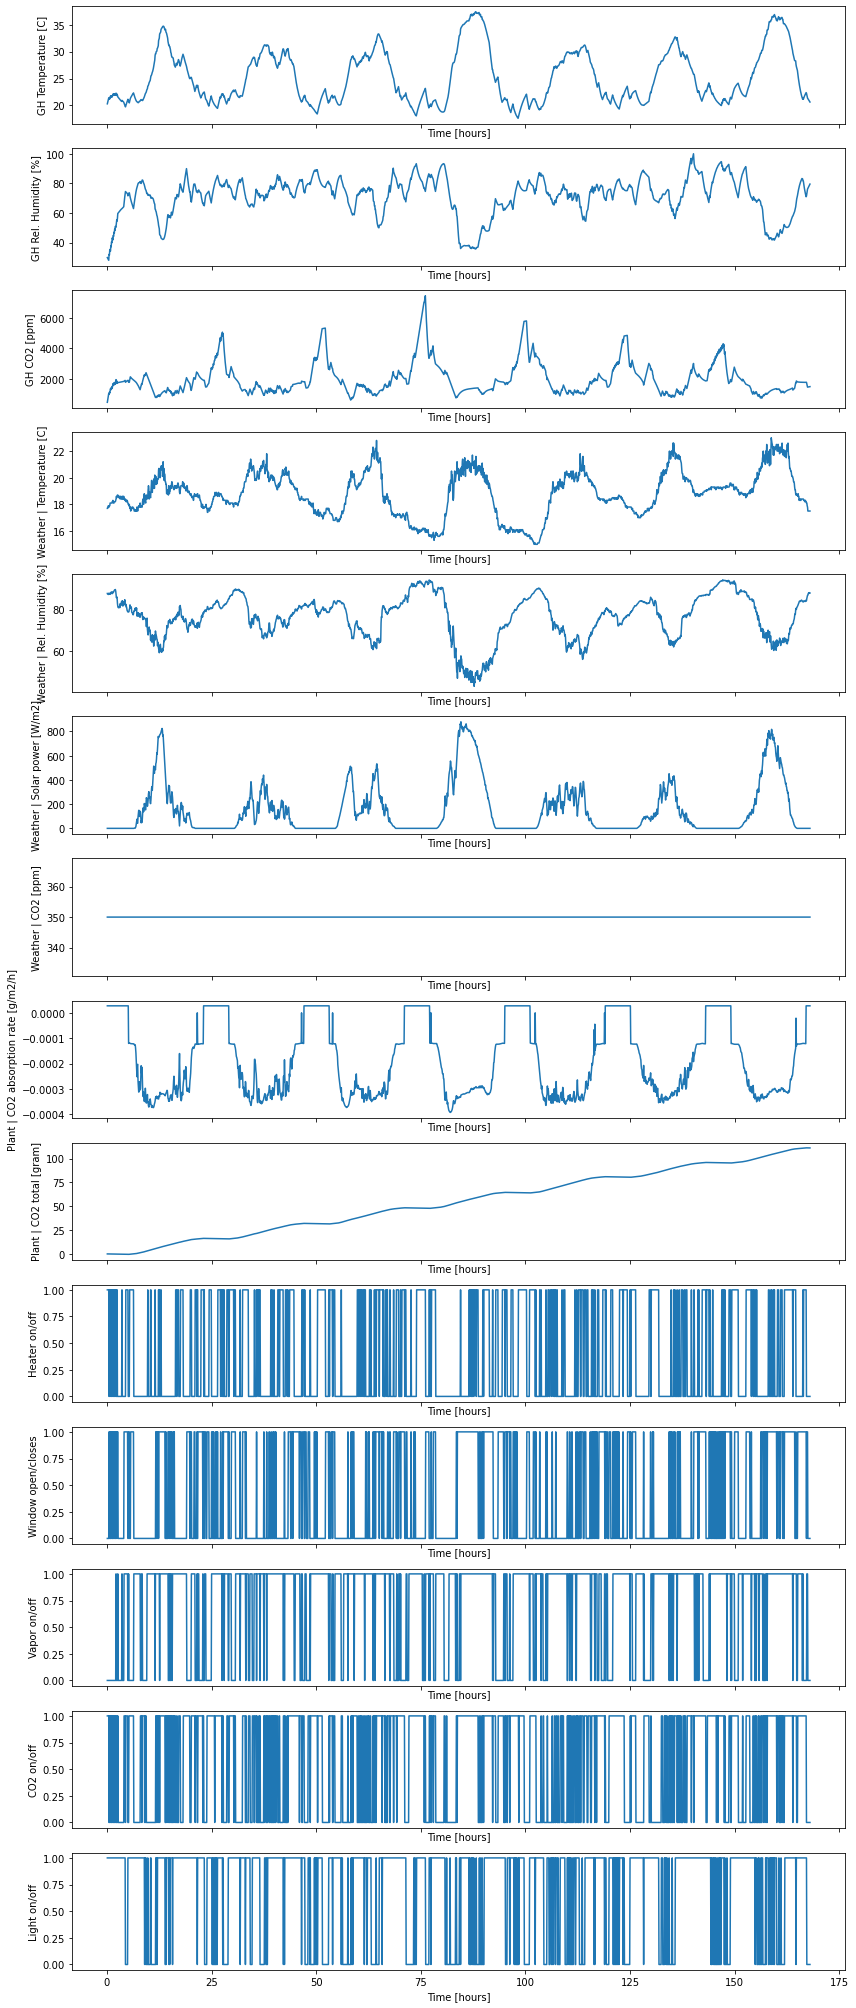

In [54]:
env = TransformObservation(GreenhouseEnv(env_config))
history_rl, summary_rl = visualize_episode(env, agent)

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


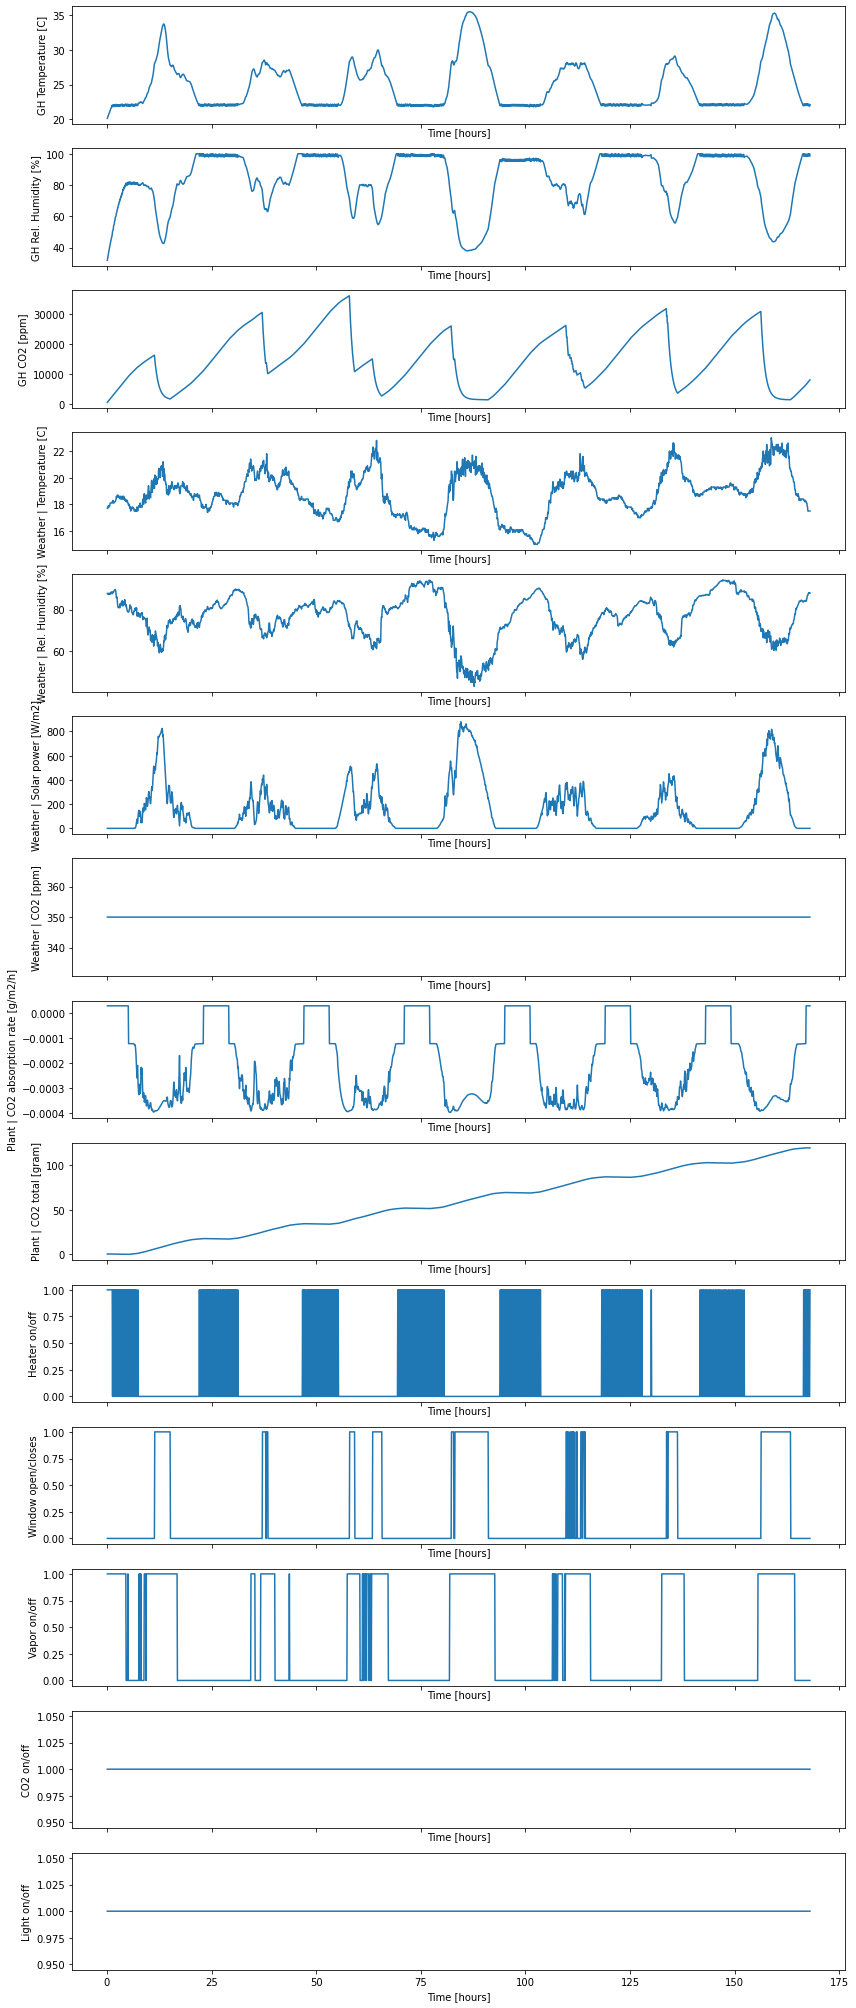

In [55]:
from greenhouse.heuristic_agents import NoCostHeuristicAgent 
from greenhouse.simulation import plot_history
env = GreenhouseEnv(env_config)
heuristic_agent = NoCostHeuristicAgent()

history_heuristic, summary_heuristic = visualize_episode(env, heuristic_agent)

In [56]:
pd.DataFrame([summary_rl, summary_heuristic], index=['rl', 'heuristic'])

mean_day_temp  mean_night_temp  cost_vapor  cost_heat  cost_CO2  \
rl             26.794988        20.842174         0.0        0.0       0.0   
heuristic      25.818741        22.025044         0.0        0.0       0.0   

           cost_light  CO2_absorbed  total_cost  total_co2_absorbtion  \
rl                  0    740.475275         0.0            740.475275   
heuristic           0    798.865266         0.0            798.865266   

           total_reward  
rl           740.475275  
heuristic    798.865266

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning:

WARN: Box bound precision lowered by casting to float32



0.3774801587301587


[Text(239.05221167686435, 215.46327272727274, 'X[0] <= 31.106\ngini = 0.47\nsamples = 2016\nvalue = [1255, 761]'),
 Text(165.14659890144276, 211.5098181818182, 'X[0] <= 25.245\ngini = 0.429\nsamples = 1744\nvalue = [1200, 544]'),
 Text(75.83475378742291, 207.55636363636364, 'X[0] <= 21.172\ngini = 0.471\nsamples = 1112\nvalue = [691, 421]'),
 Text(21.171695542707496, 203.6029090909091, 'X[0] <= 19.936\ngini = 0.365\nsamples = 450\nvalue = [342, 108]'),
 Text(8.071547752579106, 199.64945454545455, 'X[0] <= 18.492\ngini = 0.25\nsamples = 171\nvalue = [146, 25]'),
 Text(6.395347740062679, 195.696, 'X[0] <= 17.639\ngini = 0.128\nsamples = 29\nvalue = [27, 2]'),
 Text(5.570141580054591, 191.74254545454545, 'X[0] <= 17.575\ngini = 0.346\nsamples = 9\nvalue = [7, 2]'),
 Text(4.744935420046503, 187.7890909090909, 'X[0] <= 17.322\ngini = 0.219\nsamples = 8\nvalue = [7, 1]'),
 Text(3.919729260038416, 183.83563636363635, 'X[0] <= 17.236\ngini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(3.094523

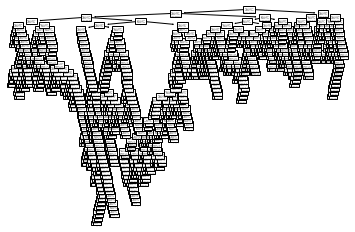

In [167]:
env = TransformObservation(GreenhouseEnv(env_config))
trajectories = sample_trajectories(env, agent, include_actions=True)

from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree

X = trajectories[:, 1:2]
y = trajectories[:, -4]
clf = DecisionTreeClassifier().fit(X, y)
print(reg.score(X, y))

data = []
for i in range(15, 60):
    data.append(reg.predict(np.array([[i]])))
plt.plot(data)

plot_tree(clf) 

In [141]:
trajectories.shape

(2016, 11)

In [123]:
import plotly.figure_factory as ff

def scatterplot(history, first, second):
    from plotly import graph_objects as go
#     bin_size = 1
#     data = []
#     uniques = np.unique(history[:, first])
#     r = 7
#     for i in range(uniques.shape[0]-r):
#         idx = (uniques[i] < history[:, first]) * (history[:, first] < (uniques[i+r]))
#         if idx.sum() > 0:
#             data.append(history[idx, second].mean())
    
    fig = go.Figure(
        [
#             go.Scatter(x=history[:, first], y=history[:, second], mode='markers')
#             go.Scatter(y=data)
            
            
        ]
    )
    fig = ff.create_2d_density(
    x=history[:, first], y=history[:, second],
    hist_color='rgb(255, 237, 222)', point_size=3
)
    fig.show()
    
scatterplot(history_rl, 1, -5)

In [107]:
np.unique(history_heuristic[:, 1]).shape

(2016,)

In [ ]:
# TODO: first heuristic and then RL
# Numbers next to each other

# Scenario 2: Non zero costs
In this scenario we would like to see how a DQN Agent would be able to ballance the costs as well.

In [16]:
env_config = {
    'greenhouse_config': {
        'cost_heat': -0.005,  # €/kW/m2
        'cost_CO2': -1000.0,  # €/kg/m2
        'cost_vapor': 0,  # €/kg/m2
        'cost_light': -1 / 7.2e5, # €/umol/m2
    }
}

In [17]:
import gym
from QLearning.dqn import DeepQNetwork, DoubleDQN, DuelingDDQN, NoisyDuelingDDQN, EpsilonGreedyAgent
from os.path import join

from greenhouse.environment import GreenhouseEnv

EXPERIMENT_FOLDER = join('Experiments', 'greenhouse_dqn_2')
save_interval = 100

env = TransformObservation(GreenhouseEnv(env_config), normalize_features)
    

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning:

WARN: Box bound precision lowered by casting to float32



In [19]:
    
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

q_network = DeepQNetwork(
    state_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
    learning_rate=0.00025,
    gamma=0.99,
    use_cnn=False,
    mlp_n_hidden=(32, 32),
    mlp_act_f="tanh",
    mlp_value_n_hidden=(64, ),
    mlp_value_act_f="tanh")
q_network.load(filepath='Experiments/greenhouse_dqn_2/run100')

agent = EpsilonGreedyAgent(
    n_actions=env.action_space.n,
    network=q_network,
    replay_capacity=10000,
    gamma=0.99,  # discount of future rewards
    training_start=100,  # start training after x number of steps
    training_interval=1,  # train every x steps
    batch_size=32,
    start_epsilon=1.0,
    end_epsilon=0.02,
    epsilon_decay=1e-5,
    root_folder=EXPERIMENT_FOLDER,
    save_best=True,
    save_interval=save_interval)

# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

Observation space: Box(-inf, inf, (10,), float32)
Action space: Discrete(32)


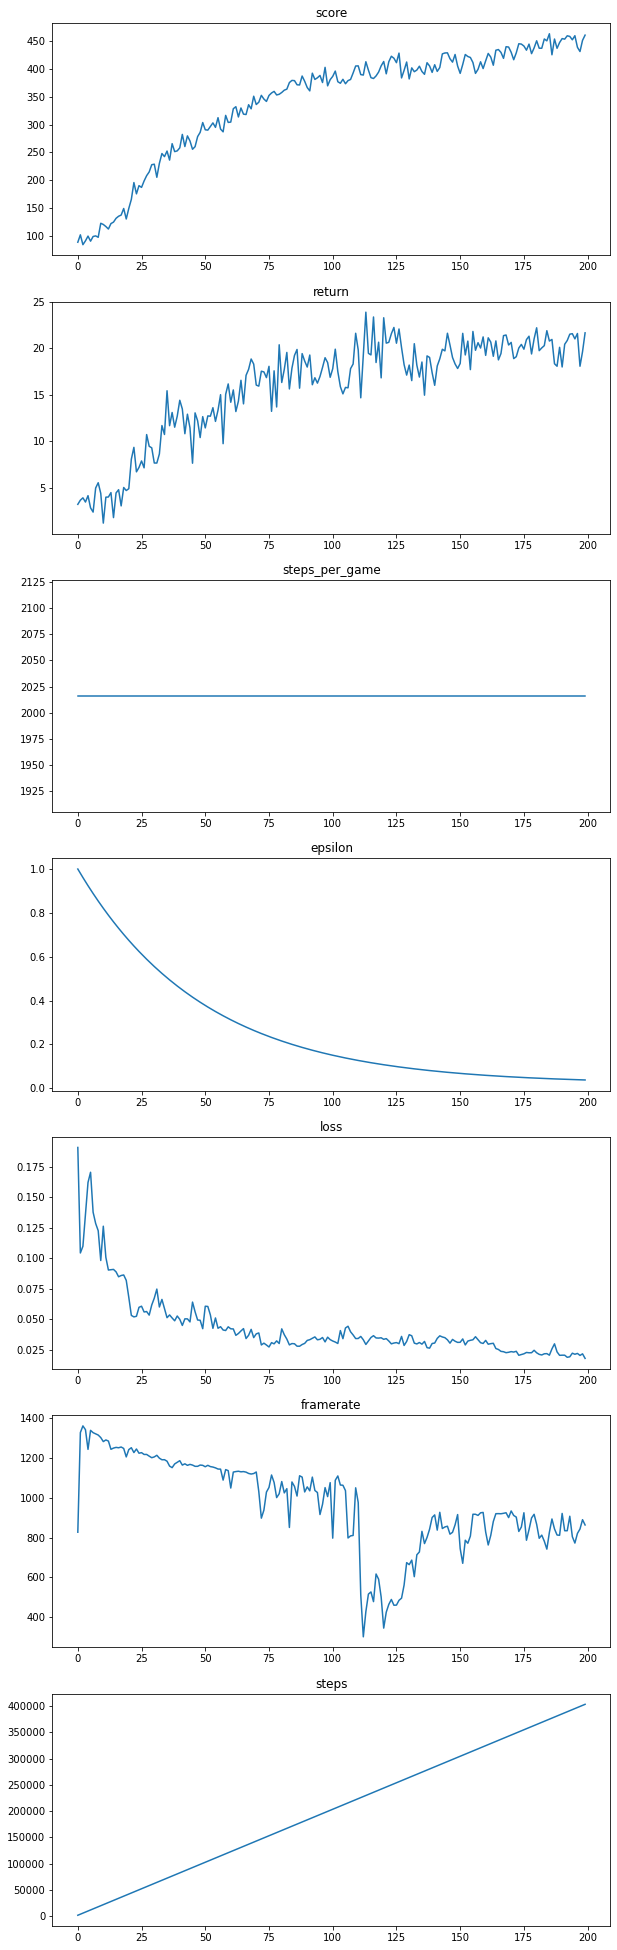

In [17]:
# Cell to train the agent. If you want to load the weights, skip this cell.
from QLearning.dqn import run_experiment

history = run_experiment(env, agent, runs=200, history=history,
               plot_stats=[
                   'score',
                   'return',
                   'steps_per_game',
                   'epsilon',
                   'loss',
                   'framerate',
                   'steps'
               ],
              plot_period=10)
env.close()

<ipython-input-37-2a062dc28d6e>:10: RuntimeWarning:

Mean of empty slice.



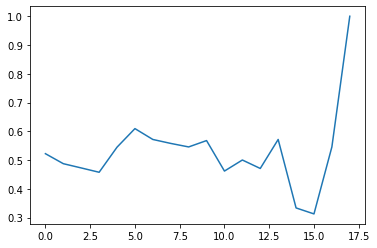

In [37]:
from plotly import graph_objects as go

# fig = go.Figure(
#     [go.Scatter(x=, y=history[:, -1], mode='markers')]
# )

d = []
for i in range(0, 20):
    idx = (i * 50 < history[:, 6]) * (history[:, 6] < i * 50 + 50)
    d.append(history[idx, -1].mean())
import matplotlib.pyplot as plt

plt.plot(d)

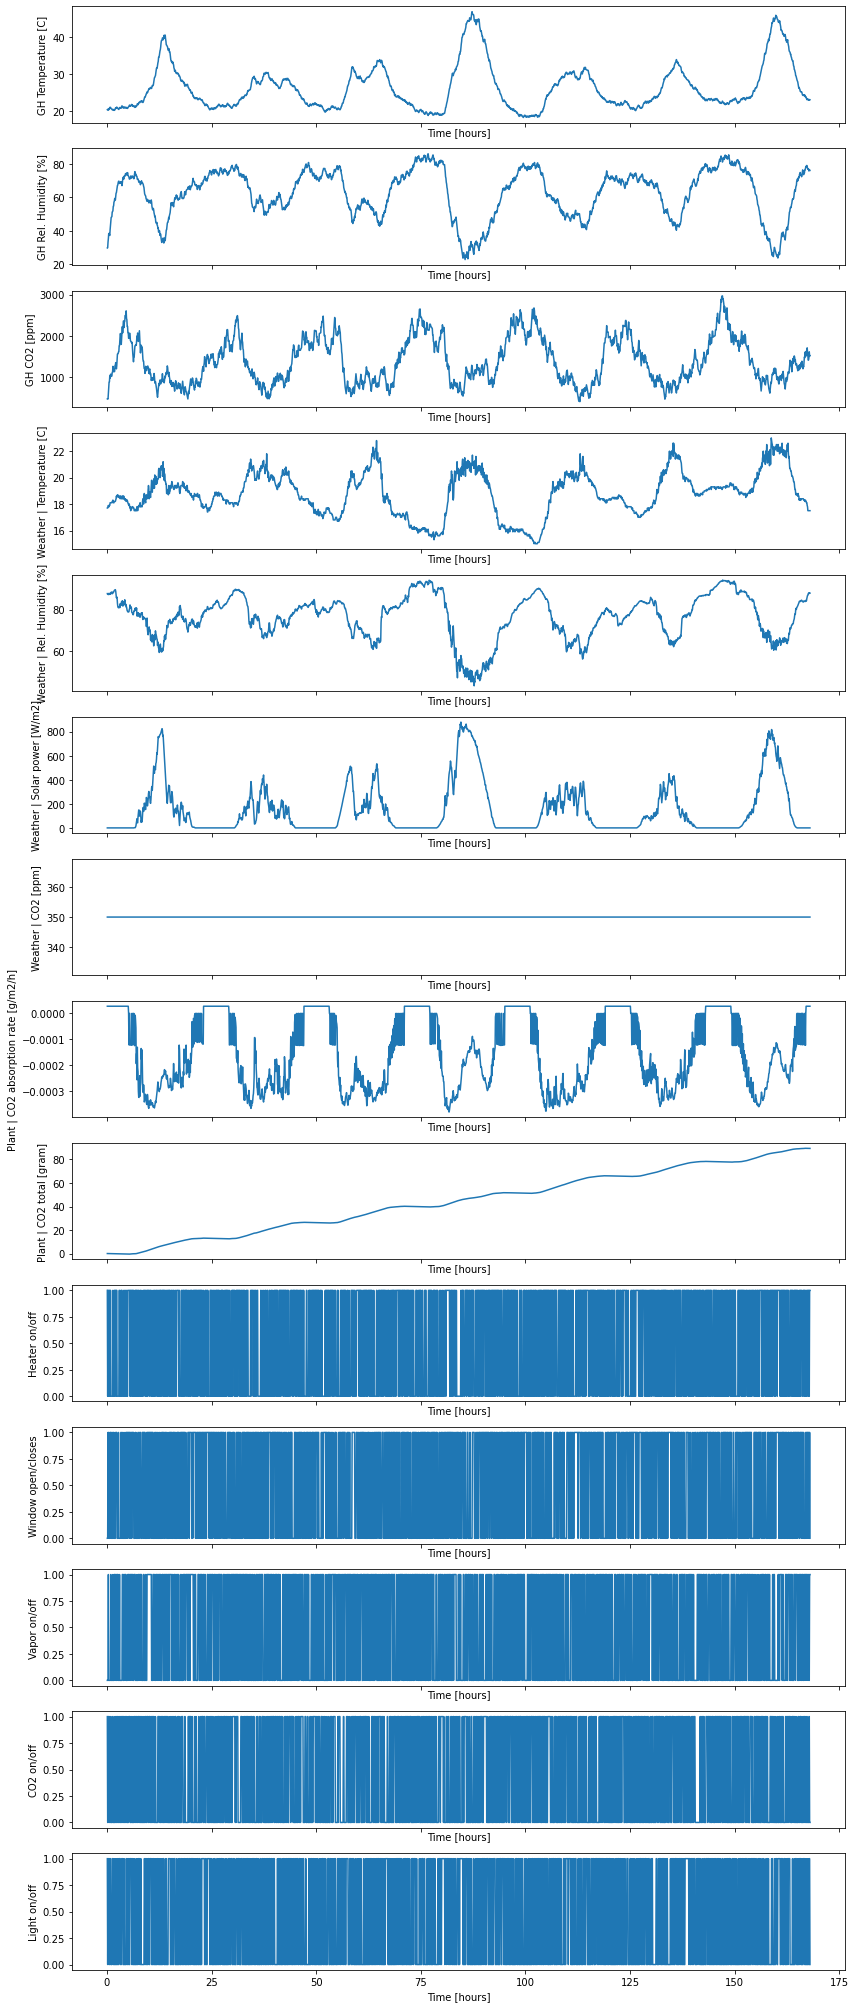

mean temp day 27.92634958053126
mean temp night 21.23910005164161
Cumulative Rewards:
{'CO2_absorbed': 596.0002000602866,
 'cost_CO2': -248.50000000000003,
 'cost_heat': -180.0000000000043,
 'cost_light': -78.07250000000018,
 'cost_vapor': 0.0}
Total Cost: -506.5725000000045
Total CO2 absorbtion: 596.0002000602866


In [20]:
history = visualize_episode(env, agent)

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning:

WARN: Box bound precision lowered by casting to float32



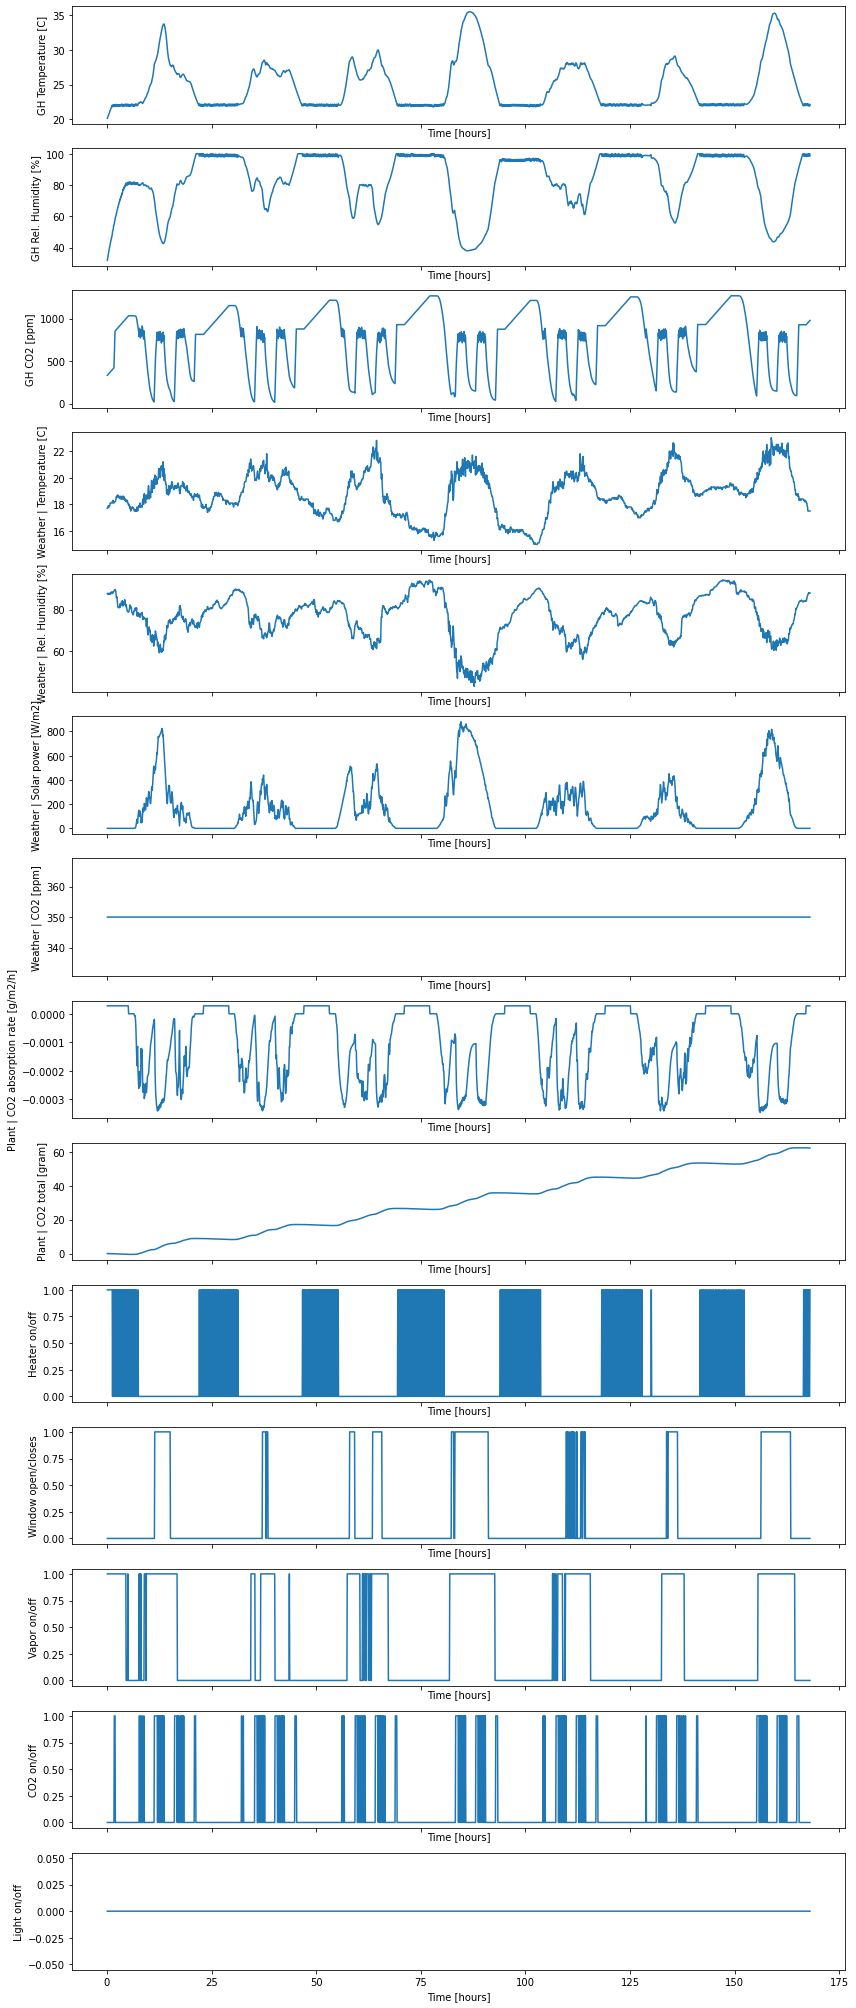

mean temp day 25.81874056314538
mean temp night 22.025044483331946
Cumulative Rewards:
{'CO2_absorbed': 415.36887308396814,
 'cost_CO2': -71.25000000000001,
 'cost_heat': -57.77999999999992,
 'cost_light': 0.0,
 'cost_vapor': 0.0}
Total Cost: -129.02999999999994
Total CO2 absorbtion: 415.36887308396814


In [19]:
from greenhouse.heuristic_agents import HeuristicAgent
env = GreenhouseEnv(env_config)
heuristic_agent = HeuristicAgent()

history = visualize_episode(env, heuristic_agent)

# Scenario 3: Increased C02 cost

In [20]:
env_config = {
    'greenhouse_config': {
        'cost_heat': -0.005,  # €/kW/m2
        'cost_CO2': -3000.0,  # €/kg/m2
        'cost_vapor': 0,  # €/kg/m2
        'cost_light': -1 / 7.2e5, # €/umol/m2
    }
}

In [21]:
import gym
from QLearning.dqn import DeepQNetwork, DoubleDQN, DuelingDDQN, NoisyDuelingDDQN, EpsilonGreedyAgent
from os.path import join

from greenhouse.environment import GreenhouseEnv

EXPERIMENT_FOLDER = join('Experiments', 'greenhouse_dqn_3')
save_interval = 100

env = TransformObservation(GreenhouseEnv(env_config), normalize_features)
    

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning:

WARN: Box bound precision lowered by casting to float32



In [22]:
    
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

q_network = DeepQNetwork(
    state_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
    learning_rate=0.00025,
    gamma=0.99,
    use_cnn=False,
    mlp_n_hidden=(32, 32),
    mlp_act_f="tanh",
    mlp_value_n_hidden=(64, ),
    mlp_value_act_f="tanh")
# q_network.load(filepath='Experiments/greenhouse_dqn/run900')

agent = EpsilonGreedyAgent(
    n_actions=env.action_space.n,
    network=q_network,
    replay_capacity=10000,
    gamma=0.99,  # discount of future rewards
    training_start=100,  # start training after x number of steps
    training_interval=1,  # train every x steps
    batch_size=32,
    start_epsilon=1.0,
    end_epsilon=0.02,
    epsilon_decay=1e-5,
    root_folder=EXPERIMENT_FOLDER,
    save_best=True,
    save_interval=save_interval)

# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

Observation space: Box(-inf, inf, (10,), float32)
Action space: Discrete(32)


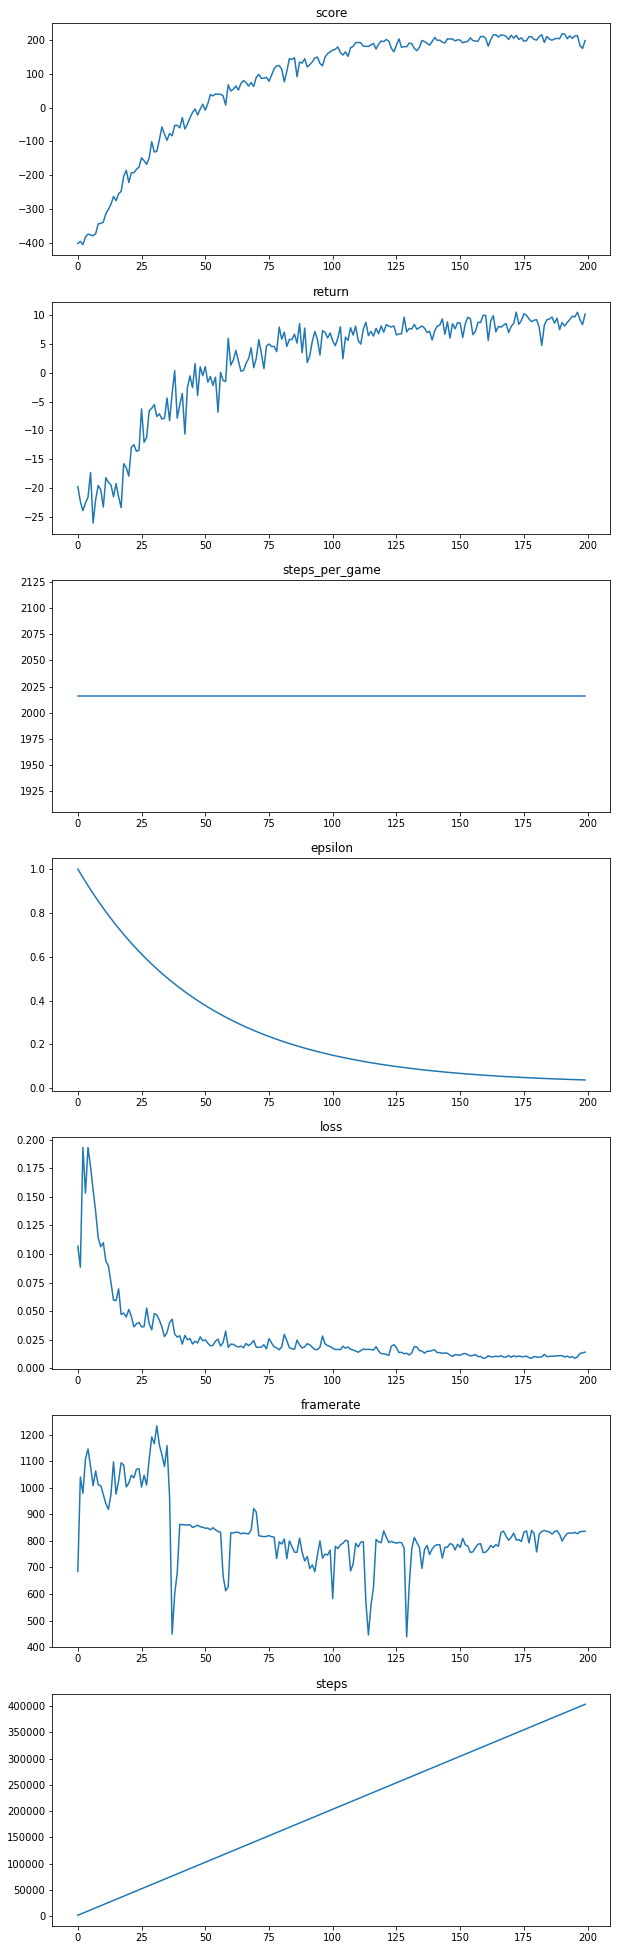

In [23]:
# Cell to train the agent. If you want to load the weights, skip this cell.
from QLearning.dqn import run_experiment

history = run_experiment(env, agent, runs=200, history=history,
               plot_stats=[
                   'score',
                   'return',
                   'steps_per_game',
                   'epsilon',
                   'loss',
                   'framerate',
                   'steps'
               ],
              plot_period=10)
env.close()

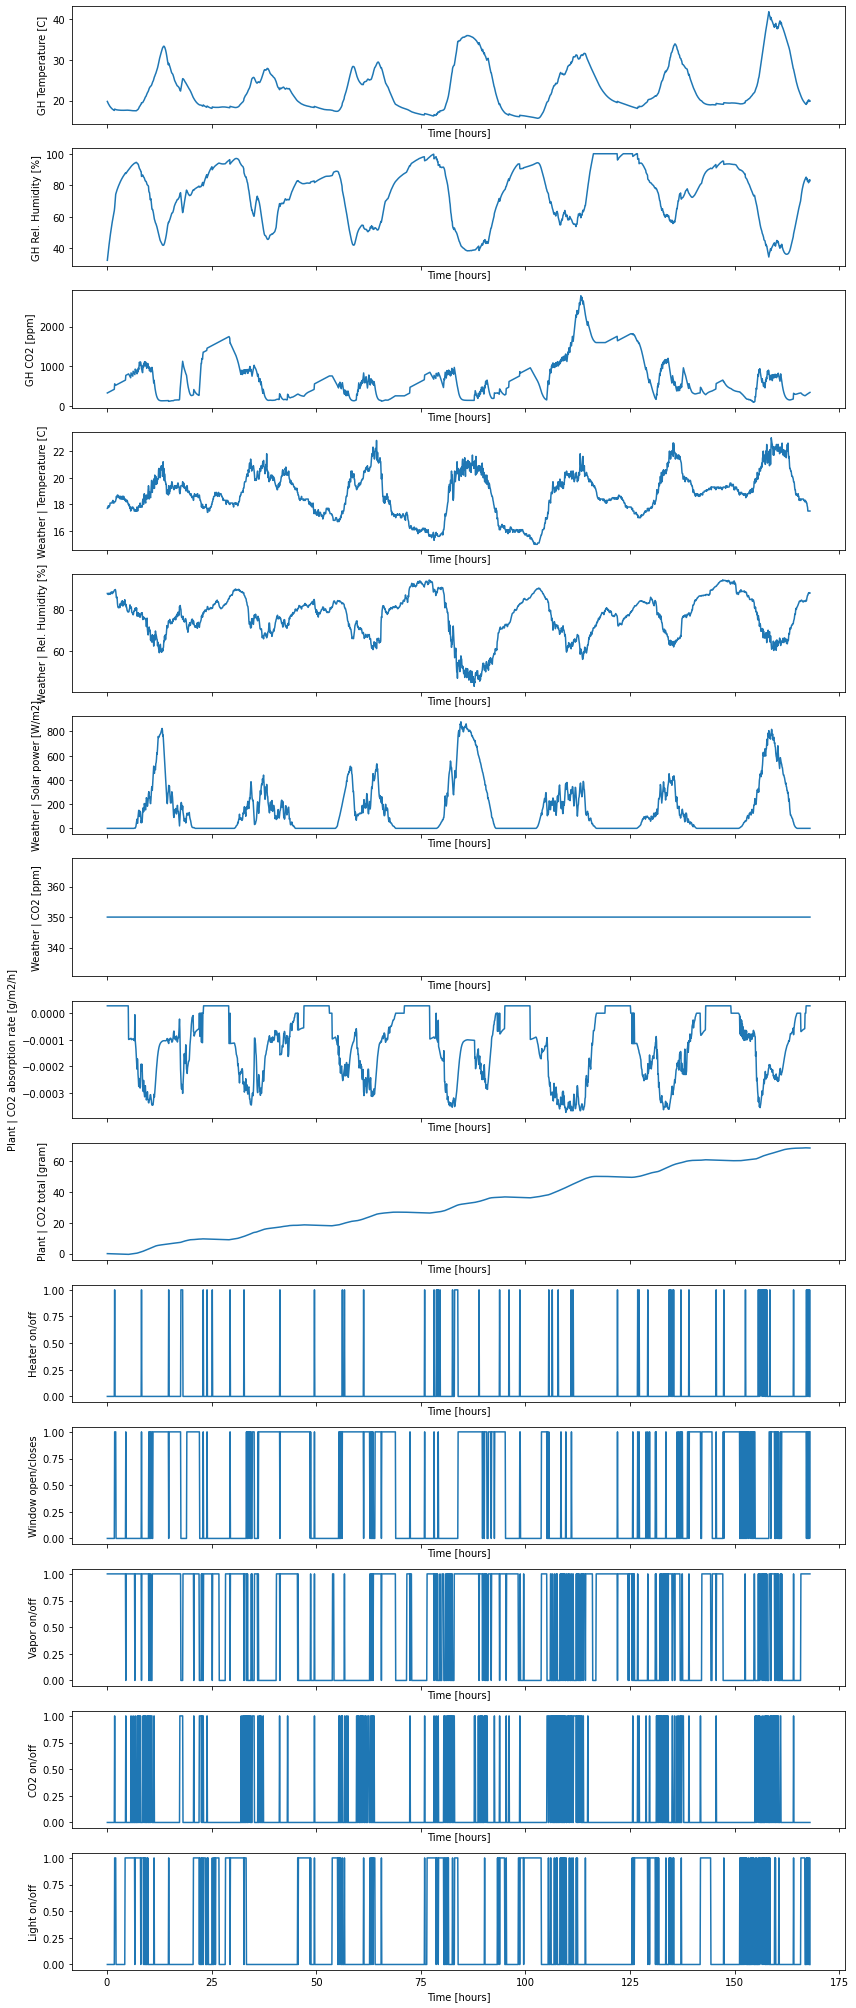

mean temp day 24.490168596037332
mean temp night 18.173381104856585
Cumulative Rewards:
{'CO2_absorbed': 455.8948303059794,
 'cost_CO2': -204.75,
 'cost_heat': -15.659999999999984,
 'cost_light': -45.50333333333344,
 'cost_vapor': 0.0}
Total Cost: -265.9133333333334
Total CO2 absorbtion: 455.8948303059794


In [24]:
history = visualize_episode(env, agent)

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning:

WARN: Box bound precision lowered by casting to float32



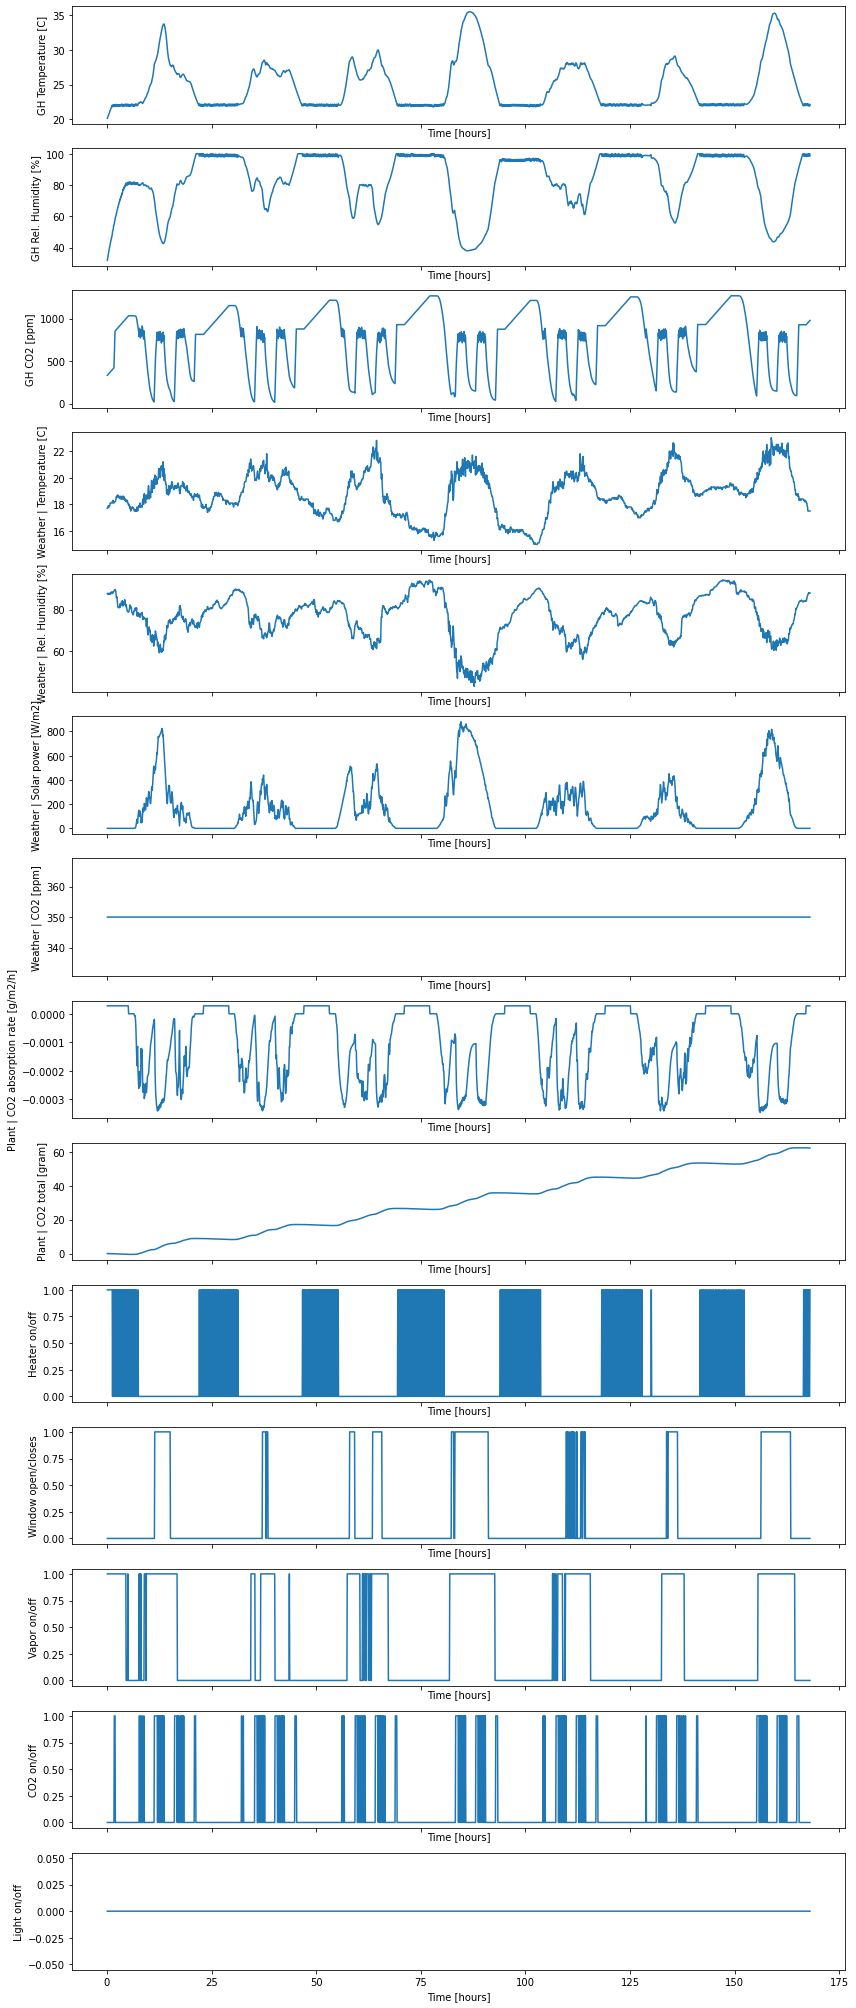

mean temp day 25.81874056314538
mean temp night 22.025044483331946
Cumulative Rewards:
{'CO2_absorbed': 415.36887308396814,
 'cost_CO2': -213.75,
 'cost_heat': -57.77999999999992,
 'cost_light': 0.0,
 'cost_vapor': 0.0}
Total Cost: -271.5299999999999
Total CO2 absorbtion: 415.36887308396814


In [25]:
from greenhouse.heuristic_agents import HeuristicAgent
env = GreenhouseEnv(env_config)
heuristic_agent = HeuristicAgent()

history = visualize_episode(env, heuristic_agent)

In [53]:
%load_ext autoreload
%autoreload 2

import os
import sys

def set_gpu(idxs=None):
    """Set visible GPUs
    ids: list of GPU ids to be visible, None to disble all GPUs
    """
    import tensorflow as tf
    gpu_devices = [x for x in tf.config.list_physical_devices() if x.device_type=='GPU']
    
    idxs = idxs or []
    set_visible = [gpu_devices[idx] for idx in idxs]
    
    try:
        # Disable all GPUS
        tf.config.set_visible_devices(set_visible, 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
    finally:
        print(tf.config.get_visible_devices())
        
# Disable GPUs        
set_gpu(idxs=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Double DQN

In [17]:
import gym
from QLearning.dqn import DeepQNetwork, DoubleDQN, DuelingDDQN, NoisyDuelingDDQN, EpsilonGreedyAgent
from os.path import join

EXPERIMENT_FOLDER = join('Experiments', 'greenhouse_double_dqn')

env = ...
        
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

q_network = DoubleDQN(
    state_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
    learning_rate=0.00025,
    gamma=0.99,
    use_cnn=False,
    mlp_n_hidden=(32, 32),
    mlp_act_f="tanh",
    mlp_value_n_hidden=(64, ),
    mlp_value_act_f="tanh",
    target_network_update_freq=5000,)
    
agent = EpsilonGreedyAgent(
    n_actions=env.action_space.n,
    network=q_network,
    replay_capacity=10000,
    gamma=0.99,  # discount of future rewards
    training_start=100,  # start training after x number of steps
    training_interval=1,  # train every x steps
    batch_size=32,
    start_epsilon=1.0,
    end_epsilon=0.02,
    epsilon_decay=1e-5,
    root_folder=EXPERIMENT_FOLDER,
    save_best=True,
    save_interval=save_interval)

# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

Observation space: Box(-inf, inf, (10,), float32)
Action space: Discrete(32)


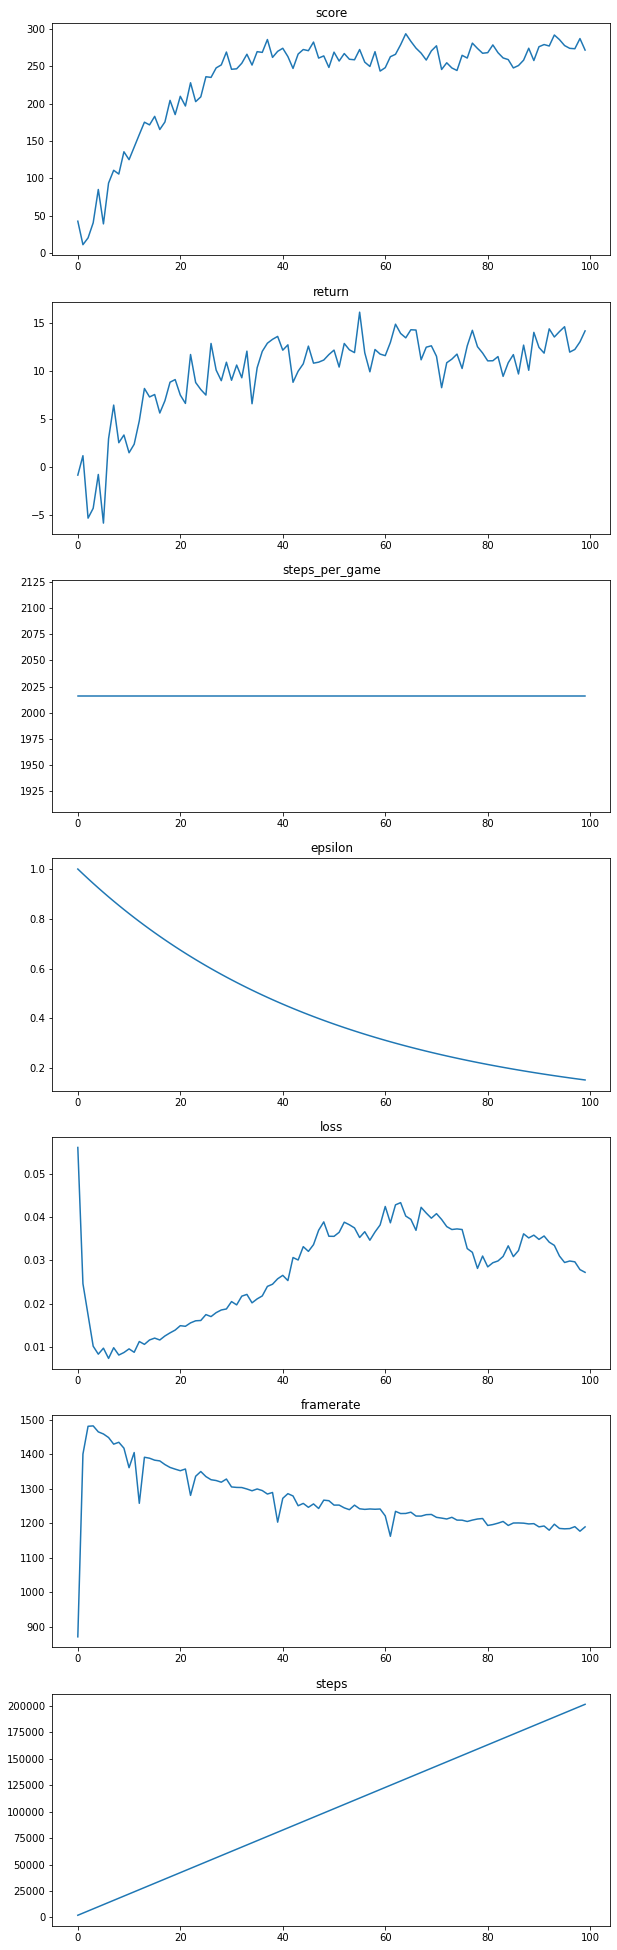

In [18]:
# Cell to train the agent. If you want to load the weights, skip this cell.
from QLearning.dqn import run_experiment

history = run_experiment(env, agent, runs=100, history=history,
               plot_stats=[
                   'score',
                   'return',
                   'steps_per_game',
                   'epsilon',
                   'loss',
                   'framerate',
                   'steps'
               ],
              plot_period=10)
env.close()

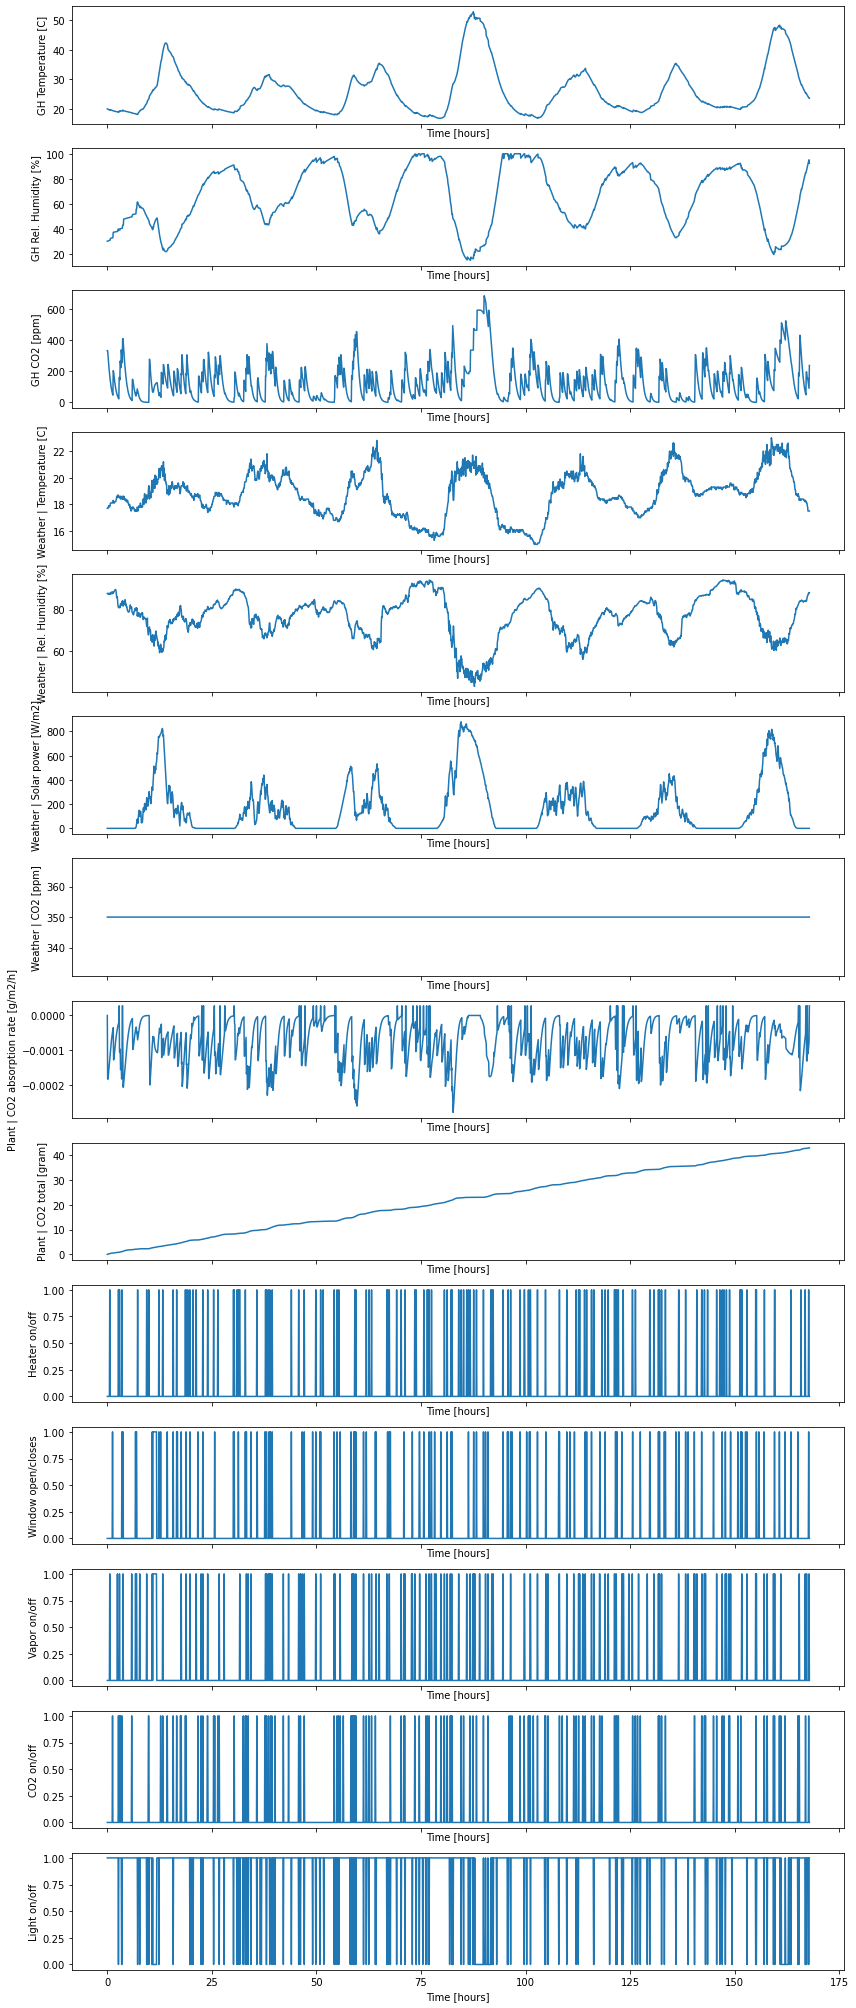

In [21]:
import numpy as np

obs = env.reset()
done = False
history = []
while not done:
    action = agent.compute_action(obs)
    next_obs, reward, done, info = env.step(action)
    action = env.action_num_to_vec[action]
    history.append(np.concatenate([obs, action]))
    obs = next_obs
import matplotlib.pyplot as plt
plot_history(np.asarray(history))
plt.show()

In [9]:
# Save the model and dump the history file
agent.save_model(join(EXPERIMENT_FOLDER, 'latest'))

# Save history file
from QLearning.dqn.run import save_history
save_history(history, join(EXPERIMENT_FOLDER, 'history.json'))

INFO:tensorflow:Assets written to: Experiments\lunar_lander_double_dqn\latest\assets


### To load the agent and play the game
- Set the experiment folder to the ```EXPERIMENT_FOLDER``` variable
- Create the environment
- Create a instance of a network.
- Load the weights with ```q_network.load(path)```
- Create an agent ```EpsilonGreedyAgent(network=q_network)```
- Remember to set ``````EpsilonGreedyAgent(start_epsilon=0.02)`````` to a small value, to ensure exploration.

In [10]:
from os.path import join

import gym

from QLearning.dqn import EpsilonGreedyAgent, DeepQNetwork

EXPERIMENT_FOLDER = join('Experiments', 'lunar_lander_double_dqn')

env = gym.make('LunarLander-v2')
q_network = DeepQNetwork(state_shape=env.observation_space.shape,
                         n_actions=env.action_space.n,
                        use_cnn=False)
# Load the network
q_network.load(join(EXPERIMENT_FOLDER, 'latest'))

agent = EpsilonGreedyAgent(n_actions=env.action_space.n, network=q_network, start_epsilon=0.02)

In [12]:
import os
from gym import wrappers
from IPython.display import Video

from QLearning.dqn.run import run_episode

eval_env = wrappers.Monitor(env, video_folder, force=True)

print(run_episode(eval_env, agent, train=False))

# take the last element in the folder with .mp4 extension
video_name = [x for x in os.listdir(video_folder) if '.mp4' in x][-1]
Video(os.path.join(video_folder, video_name), embed=True)

{'score': 217.68130979658392, 'steps_per_game': 483, 'framerate': 51.86485003059262, 'runs': 1, 'return': 0, 'epsilon': 0.02, 'loss': 0, 'steps': 0}


In [15]:
# Save the model and dump the history file
agent.save_model(join(EXPERIMENT_FOLDER, 'latest'))

from QLearning.dqn import save_history
save_history(history, join(EXPERIMENT_FOLDER, 'history.json'))

INFO:tensorflow:Assets written to: Experiments\lunar_lander_double_dqn\latest\assets


dict_keys(['score', 'steps_per_game', 'framerate', 'runs', 'return', 'epsilon', 'loss', 'steps', 'total_steps', 'total_episodes'])


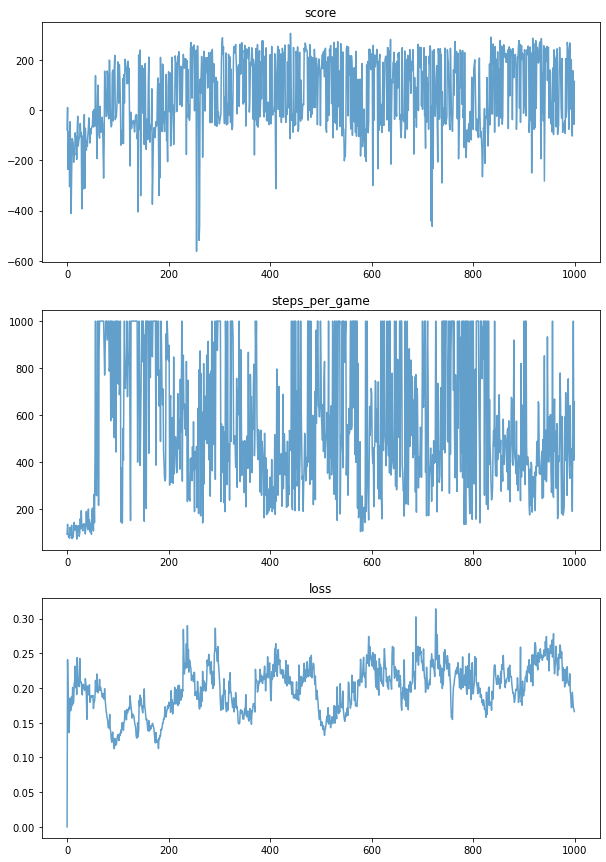

In [17]:
from QLearning.dqn.run import load_history, plot_history
import matplotlib.pyplot as plt

from os.path import join

history = load_history(join(EXPERIMENT_FOLDER, 'history.json'))
print(history.keys())
plot_history(history, ['score', 'steps_per_game', 'loss'])

You can also plot several histories alongside each other. Just pass a list of histories and names.

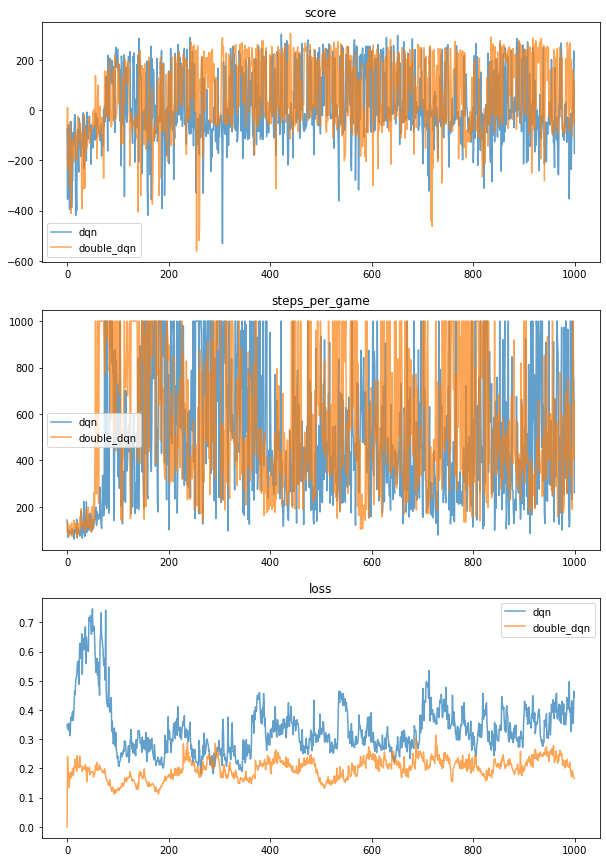

In [23]:
elems = ['score', 'steps_per_game', 'loss']

history_dqn = load_history(join('Experiments', 'lunar_lander_dqn', 'history.json'))
history_ddqn = load_history(join('Experiments', 'lunar_lander_double_dqn', 'history.json'))



plot_history([history_dqn, history_ddqn], elems, names=['dqn', 'double_dqn'])

## Excercise
Other networks are available with `from QLearning.dqn import DeepQNetwork, DoubleDQN, DuelingDDQN, NoisyDuelingDDQN, EpsilonGreedyAgent`. Try different environments, configurations and extensions.
Try changing:
- `update_target_network_freq`
- `learning_rate`
- number of layers, neurons
- activation function
- weight initialization
- regularization terms

What is the effect on the learning process?